In [31]:
import torch
from torch import nn
from tqdm import tqdm

class QuadrupletNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_units):
        super(QuadrupletNetwork, self).__init__()
        self.fc1 = nn.Linear(512, hidden_units)
        self.fc2 = nn.Linear(hidden_units, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return nn.functional.normalize(x, dim=-1)

def quadruplet_loss(margin_s, margin_c, margin_n):
    def loss(y_pred):
        anchor, similar, complement, negative = torch.unbind(y_pred, dim=1)
        loss_s = torch.clamp(margin_s - (anchor * similar).sum(dim=-1), min=0)
        loss_c = torch.clamp((anchor * complement).sum(dim=-1) - margin_c, min=0)
        loss_n = torch.clamp(margin_n - (anchor * negative).sum(dim=-1), min=0)
        return (loss_s + loss_c + loss_n).sum()
    return loss

# Instantiate the model
model = QuadrupletNetwork(embedding_dim=128, hidden_units=256)

# Compile the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # L2 regularization is added here
criterion = quadruplet_loss(margin_s=0.1, margin_c=0.4, margin_n=0.8)

# Generate dummy data
n_samples = 10000
n_items = 4  # anchor, similar, complement, negative
embedding_dim = 512
X_train = torch.nn.functional.normalize(torch.rand(n_samples, n_items, embedding_dim), dim=-1)

# Train the model
for epoch in tqdm(range(30)):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs)
    loss.backward()
    optimizer.step()

# Generate dummy test data
n_test_samples = 1000
X_test = torch.nn.functional.normalize(torch.rand(n_test_samples, n_items, embedding_dim), dim=-1)

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs)
    print(f'Test loss: {loss.item()}')


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

Test loss: 420.6340637207031


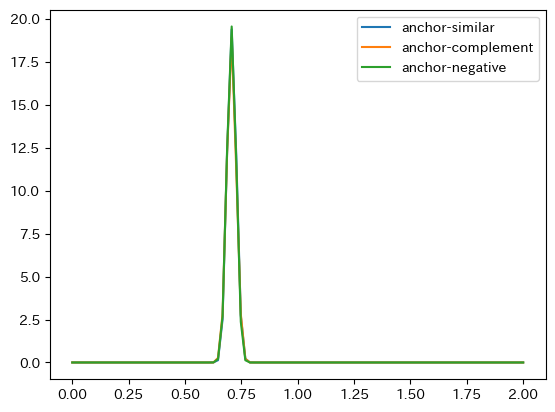

In [34]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

# ベクトルの距離を計算する
# https://pytorch.org/docs/stable/generated/torch.nn.PairwiseDistance.html
l2_dist = torch.nn.PairwiseDistance(p=2)
anchor_sim = l2_dist(X_train[:,0], X_train[:,1])
anchor_comp = l2_dist(X_train[:,0], X_train[:,2])
anchor_neg = l2_dist(X_train[:,0], X_train[:,3])

# 確率密度関数を計算する
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
def get_pdf(dist: torch.Tensor) -> np.ndarray:
    kde = gaussian_kde(dist.detach().numpy())
    def pdf(x):
        return kde(x)
    return pdf

anchor_sim_kde = get_pdf(anchor_sim)
anchor_comp_kde = get_pdf(anchor_comp)
anchor_neg_kde = get_pdf(anchor_neg)

# 確率密度関数をプロットする
x = np.linspace(0, 2, 100)
plt.plot(x, anchor_sim_kde(x), label='anchor-similar')
plt.plot(x, anchor_comp_kde(x), label='anchor-complement')
plt.plot(x, anchor_neg_kde(x), label='anchor-negative')
plt.legend()
plt.show()

In [37]:
X_train.shape

torch.Size([10000, 4, 512])

In [36]:
model(X_train[:,0]).shape

torch.Size([10000, 128])

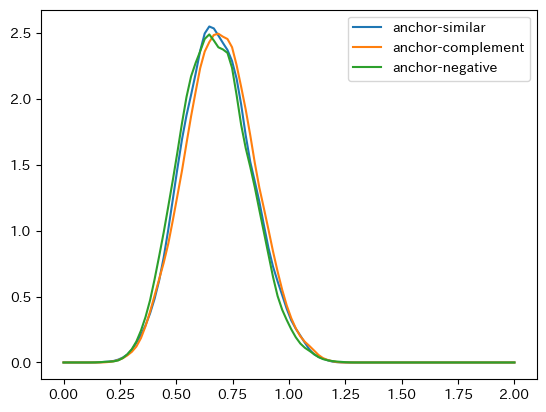

In [35]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

# ベクトルの距離を計算する
# https://pytorch.org/docs/stable/generated/torch.nn.PairwiseDistance.html
anchor_embed = model(X_train[:,0])
similar_embed = model(X_train[:,1])
complement_embed = model(X_train[:,2])
negative_embed = model(X_train[:,3])
l2_dist = torch.nn.PairwiseDistance(p=2)
anchor_sim = l2_dist(anchor_embed, similar_embed)
anchor_comp = l2_dist(anchor_embed, complement_embed)
anchor_neg = l2_dist(anchor_embed, negative_embed)

# 確率密度関数を計算する
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
def get_pdf(dist: torch.Tensor) -> np.ndarray:
    kde = gaussian_kde(dist.detach().numpy())
    def pdf(x):
        return kde(x)
    return pdf

anchor_sim_kde = get_pdf(anchor_sim)
anchor_comp_kde = get_pdf(anchor_comp)
anchor_neg_kde = get_pdf(anchor_neg)

# 確率密度関数をプロットする
x = np.linspace(0, 2, 100)
plt.plot(x, anchor_sim_kde(x), label='anchor-similar')
plt.plot(x, anchor_comp_kde(x), label='anchor-complement')
plt.plot(x, anchor_neg_kde(x), label='anchor-negative')
plt.legend()
plt.show()

In [38]:
import pandas as pd
import numpy as np

# サンプルデータを生成
data = {
    'product_code1': [1, 2, 3],
    'candidates': [
        np.array([
            {'product_code2': 10, 'distance': 0.5},
            {'product_code2': 11, 'distance': 0.6},
        ]),
        np.array([
            {'product_code2': 12, 'distance': 0.7},
        ]),
        np.array([
            {'product_code2': 13, 'distance': 0.8},
            {'product_code2': 14, 'distance': 0.9},
            {'product_code2': 15, 'distance': 1.0},
        ])
    ]
}

df = pd.DataFrame(data)
df

,product_code1,candidates
0,1,"[{'product_code2': 10, 'distance': 0.5}, {'pro..."
1,2,"[{'product_code2': 12, 'distance': 0.7}]"
2,3,"[{'product_code2': 13, 'distance': 0.8}, {'pro..."


In [46]:
arr_product_code1 = df.product_code1.values
arr_candidates = df.candidates.values
arr_product_code1, arr_candidates

(array([1, 2, 3]),
 array([array([{'product_code2': 10, 'distance': 0.5},
               {'product_code2': 11, 'distance': 0.6}], dtype=object),
        array([{'product_code2': 12, 'distance': 0.7}], dtype=object),
        array([{'product_code2': 13, 'distance': 0.8},
               {'product_code2': 14, 'distance': 0.9},
               {'product_code2': 15, 'distance': 1.0}], dtype=object)],
       dtype=object))

In [47]:
# DataFrameを展開
expanded_rows = []
for p, candidates in zip(arr_product_code1, arr_candidates):
    product_code1 = p
    for candidate in candidates:
        expanded_rows.append({
            'product_code1': product_code1,
            'product_code2': candidate['product_code2'],
            'distance': candidate['distance']
        })

expanded_df = pd.DataFrame(expanded_rows)

print(expanded_df)


   product_code1  product_code2  distance
0              1             10       0.5
1              1             11       0.6
2              2             12       0.7
3              3             13       0.8
4              3             14       0.9
5              3             15       1.0


In [50]:
expanded_df

,product_code1,product_code2,distance
0,1,10,0.5
1,1,11,0.6
2,2,12,0.7
3,3,13,0.8
4,3,14,0.9
5,3,15,1.0


In [51]:
# distance列を２乗した列を追加
expanded_df['distance2'] = expanded_df.distance ** 2

In [52]:
expanded_df

,product_code1,product_code2,distance,distance2
0,1,10,0.5,0.25
1,1,11,0.6,0.36
2,2,12,0.7,0.49
3,3,13,0.8,0.64
4,3,14,0.9,0.81
5,3,15,1.0,1.00
